# AIN313: Machine Learning Lab - Fall 2024
## **Assignment 2**  
#### Instructor: Erkut Erdem
#### TA: Görkem Akyıldız 

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016

---

# **PART I: Theory Questions**

## **Question 1**

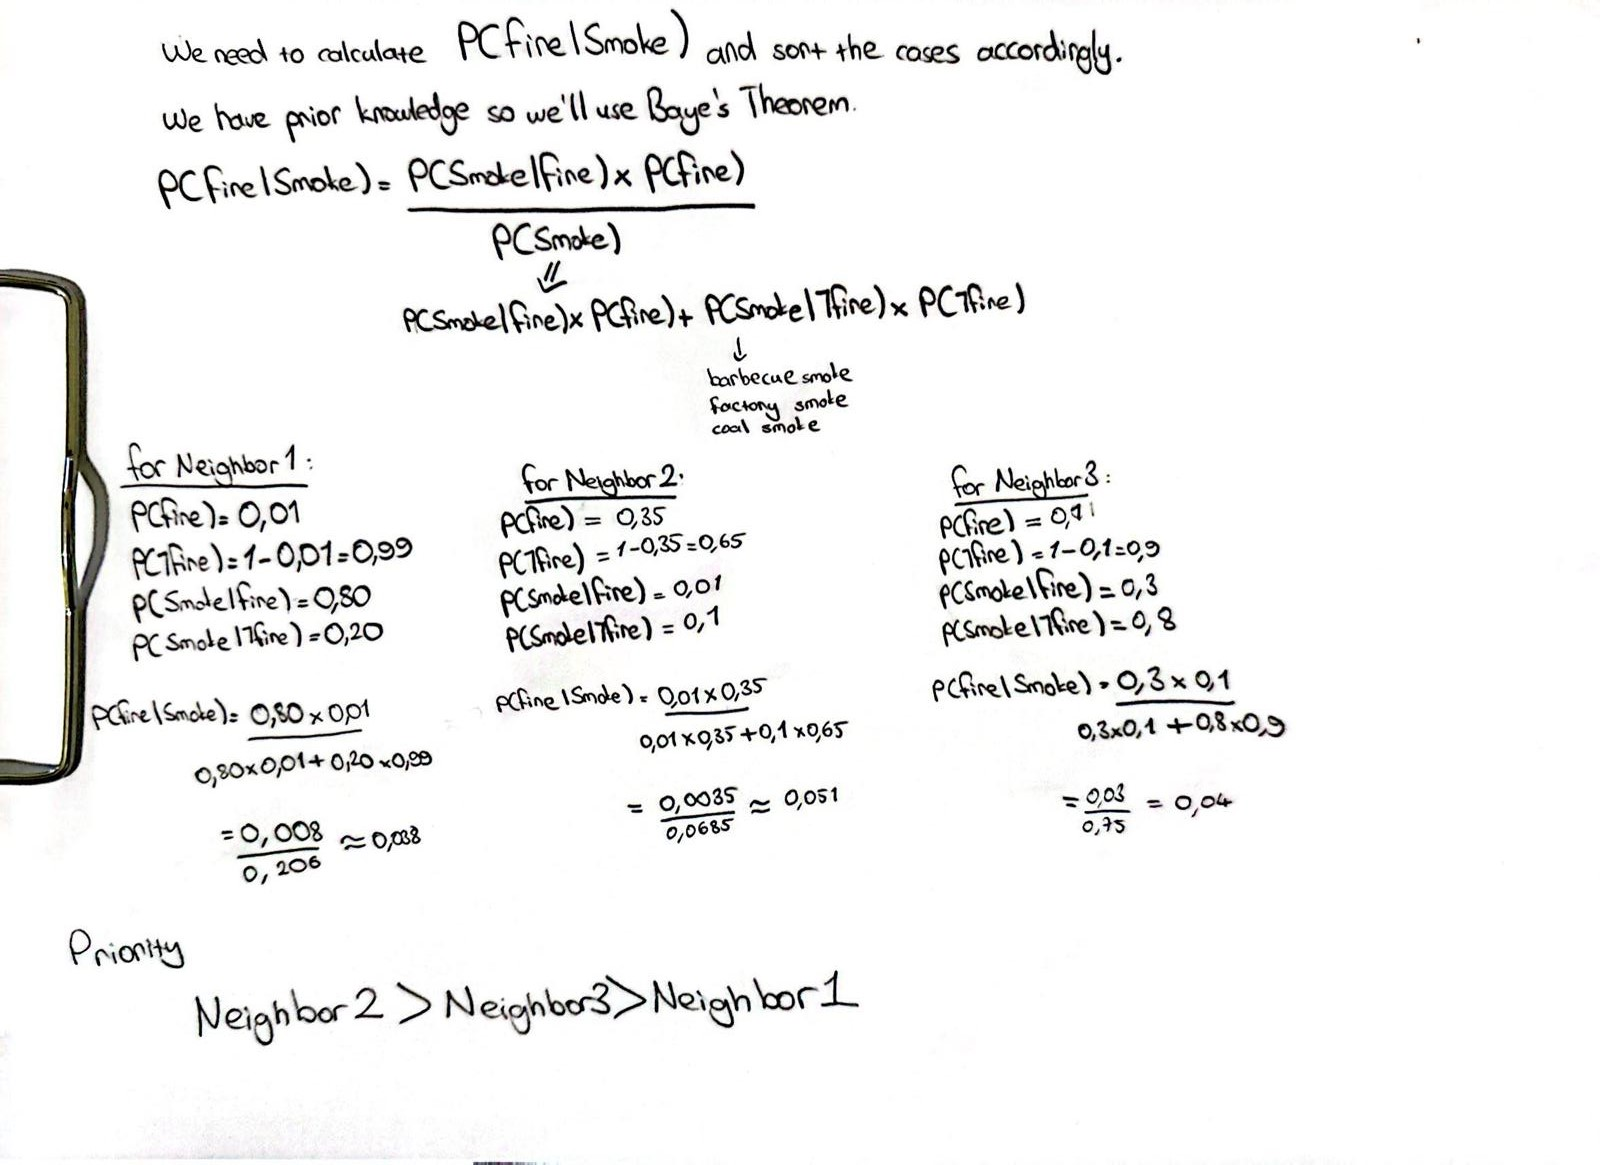

Explanation:

- Neighborhood 2 has the highest probability of a dangerous fire given the smoke, despite the low likelihood of smoke given a dangerous fire (1%). This is because the prior probability of a dangerous fire is relatively high (35%), and the alternative source of smoke (factory smoke) is less common compared to other neighborhoods.

- Neighborhood 3 has a moderate prior probability of a dangerous fire (10%) and a higher likelihood of smoke given a dangerous fire (30%). However, the high probability of smoke from coal usage (80%) dilutes the posterior probability.

- Neighborhood 1 has a very low prior probability of a dangerous fire (1%), and although the likelihood of smoke given a dangerous fire is high (80%), the high probability of smoke from barbecues (20%) and low prior make the posterior probability lowest among the three.

## **Question 2**

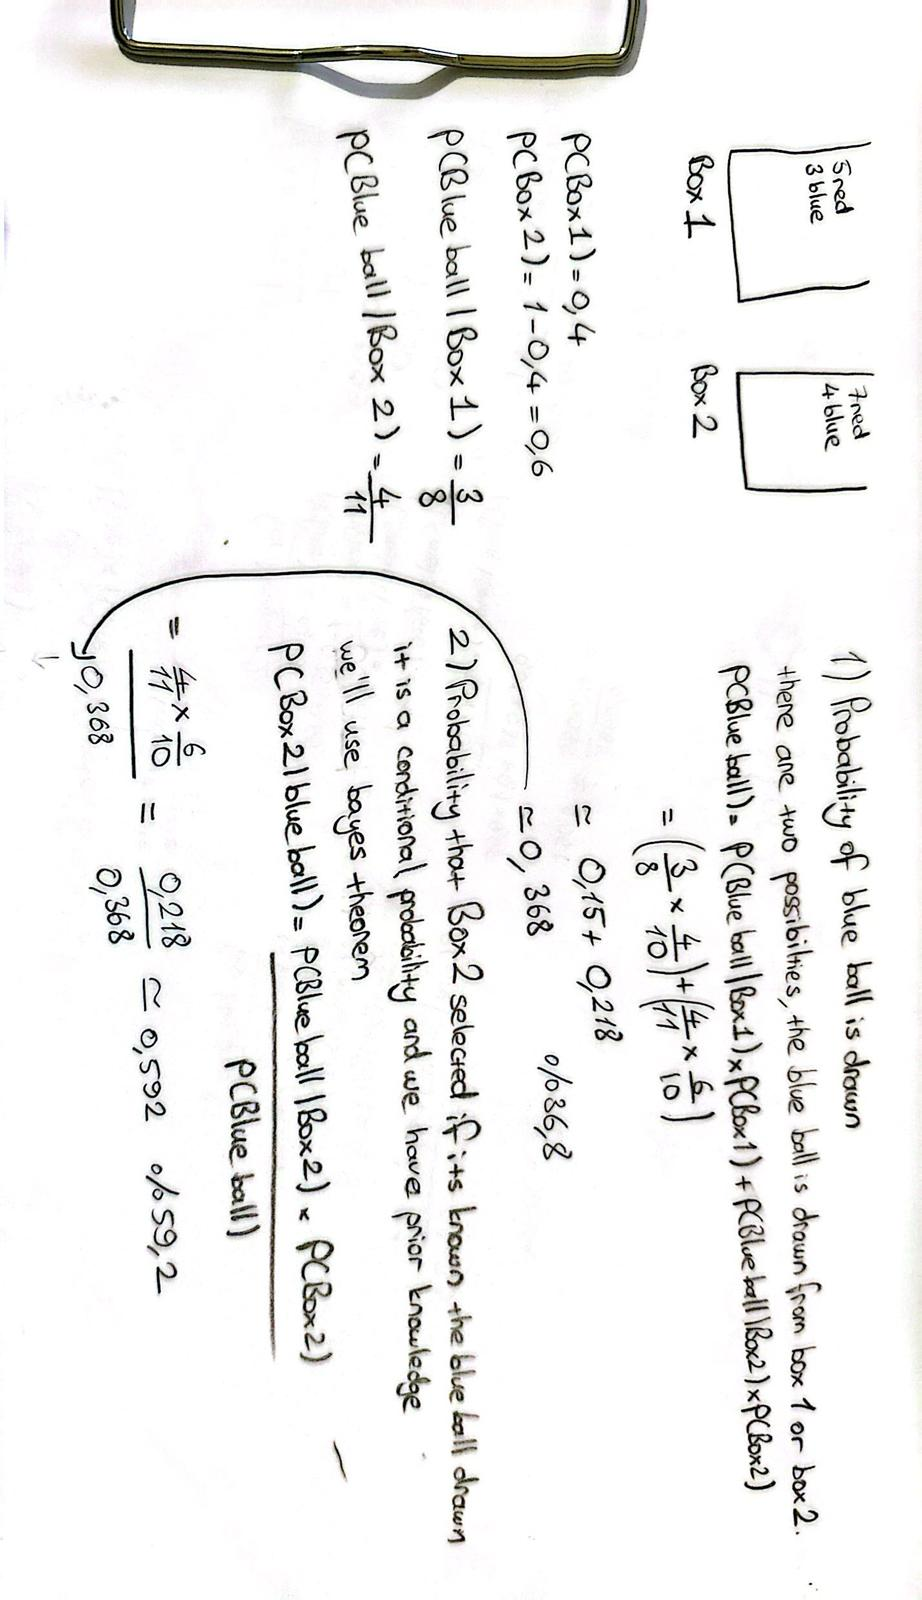

Explanation:

- The total probability of drawing a blue ball accounts for both scenarios (selecting Box 1 or Box 2) and the probabilities associated with each.
- By calculating the exact fraction, we see that there is a higher probability that the blue ball came from Box 2, given that a blue ball was drawn. This is because Box 2 has more blue balls relative to its total number of balls and a higher selection probability.

## **Question 3**


1. **Text classification is the primary application for Naïve Bayes classifier methods.**
   - **(True)**

   **Explanation:**  Naïve Bayes classifiers are extensively used in text classification tasks due to their efficiency and simplicity in handling high-dimensional data like text. The method assumes feature independence, which, while a simplification, works reasonably well with text data where the presence of certain words can be strong indicators of specific classes. Common applications include spam detection, sentiment analysis, and document categorization, making text classification a primary application area for Naïve Bayes methods.

3. **When an attribute value in the testing record has no example in the training set, the total posterior probability in a Naïve Bayes algorithm will be zero.**
   - **(False)**

   **Explanation:**  
   In the basic Naïve Bayes algorithm, if an attribute value in the test instance hasn't been seen in the training data for a particular class, the likelihood for that feature would be zero, which could indeed make the posterior probability zero. However, this problem is typically addressed using smoothing techniques like Laplace smoothing. These techniques adjust the probability estimates to account for unseen attribute values, preventing the posterior probability from becoming zero. Therefore, with proper smoothing, the posterior probability does not drop to zero even if some attribute values are unseen in the training set.
---

# **PART II: Movie Review Classification System**

### **Introduction**
Sentiment analysis is a crucial task in natural language processing (NLP) that involves determining the sentiment or emotion expressed in textual data. In this assignment, we aim to classify movie reviews from the IMDb dataset as positive or negative using a Naive Bayes classifier. We explore the effectiveness of unigram, bigram, and trigram models, as well as a combined model that leverages all three n-gram levels.

### **Overview of the Problem**
The IMDb movie review dataset consists of 50,000 reviews split evenly between positive and negative sentiments. Our goal is to build a classifier that can accurately predict the sentiment of unseen reviews. The challenge lies in effectively preprocessing the text data, handling vocabulary, and implementing the Naive Bayes algorithm for different n-gram models.

### **Implementation Details**
The implementation is structured into several key components:

1. Data Loading and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Text Preprocessing
4. N-gram Generation and Vocabulary Creation
5. Naive Bayes Classifier Implementation
6. Model Evaluation
7. Discussion of Results

### 1. Data Loading and Preprocessing
We begin by importing necessary libraries and defining paths to the dataset.

<span style="color: orange;">I used gensim Word2Vec model in the bonus part, for compatibility we need numpy 1.26.4 version.</span>r

In [16]:
!pip install pandas
!pip install numpy==1.26.4
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install scikit-learn

In [17]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

**Dataset directories**

In [19]:
dataset_dir = 'aclImdb'

train_pos_dir = os.path.join(dataset_dir, 'train/pos')
train_neg_dir = os.path.join(dataset_dir, 'train/neg')

test_pos_dir = os.path.join(dataset_dir, 'test/pos')
test_neg_dir = os.path.join(dataset_dir, 'test/neg')


**Loading Reviews**


In [21]:
# We create a function to load reviews and their corresponding labels.
def load_reviews_from_dir(directory, label):
    reviews = []
    for filename in glob.glob(os.path.join(directory, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as f:
            review = f.read()
            reviews.append(review)
    labels = [label] * len(reviews)
    return reviews, labels

# Load training data
train_reviews = []
train_labels = []

# Positive training reviews
pos_reviews, pos_labels = load_reviews_from_dir(train_pos_dir, 1)
train_reviews.extend(pos_reviews)
train_labels.extend(pos_labels)

# Negative reviews
neg_reviews, neg_labels = load_reviews_from_dir(train_neg_dir, 0)
train_reviews.extend(neg_reviews)
train_labels.extend(neg_labels)

train_data = pd.DataFrame({'review': train_reviews, 'label': train_labels})
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Load test data
test_reviews = []
test_labels = []

# Positive test reviews
pos_reviews, pos_labels = load_reviews_from_dir(test_pos_dir, 1)
test_reviews.extend(pos_reviews)
test_labels.extend(pos_labels)

# Negative test reviews
neg_reviews, neg_labels = load_reviews_from_dir(test_neg_dir, 0)
test_reviews.extend(neg_reviews)
test_labels.extend(neg_labels)

test_data = pd.DataFrame({'review': test_reviews, 'label': test_labels})
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)


### 2. Exploratory Data Analysis (EDA)

In [23]:
train_data.head()


,review,label
0,In Panic In The Streets Richard Widmark plays ...,1
1,If you ask me the first one was really better ...,0
2,I am a big fan a Faerie Tale Theatre and I've ...,1
3,I just finished reading a book about Dillinger...,0
4,Greg Davis and Bryan Daly take some crazed sta...,0


**Label Distribution**


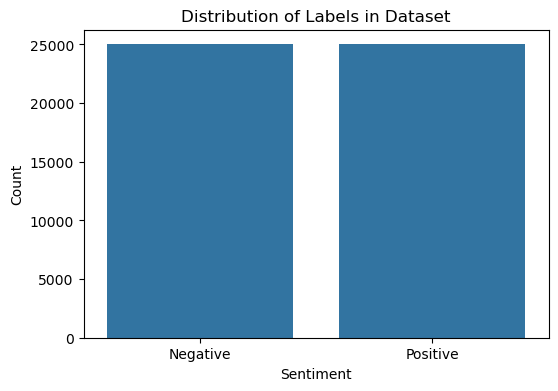

In [25]:
# Combine train and test data for visualization
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Visualize the distribution of labels in the dataset to ensure it's balanced
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=combined_data)
plt.title('Distribution of Labels in Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


**Review Length Analysis**


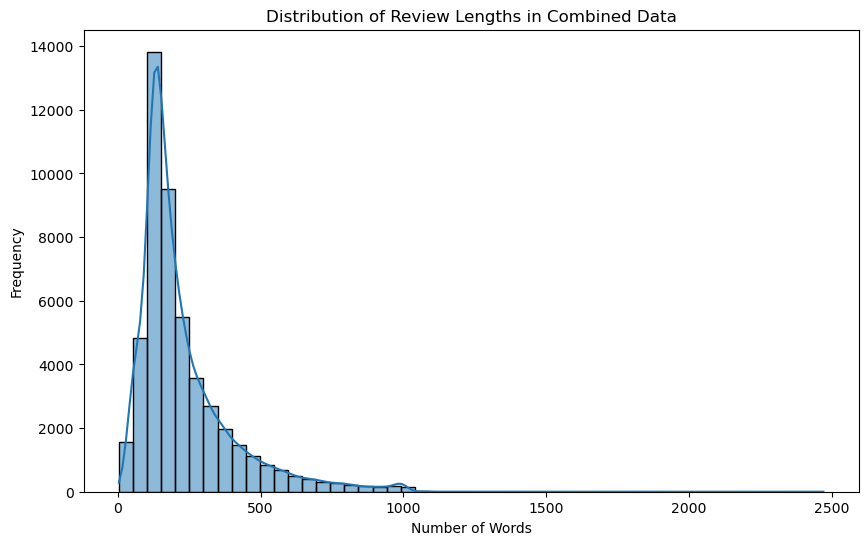

In [27]:
# Calculate review lengths
combined_data['review_length'] = combined_data['review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths in combined data
plt.figure(figsize=(10,6))
sns.histplot(combined_data['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths in Combined Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


**Distribution of Review Lengths**:
   - The histogram shows that most reviews in the data are relatively short, with a significant number clustering around 100-200 words.
   - There is a long tail, indicating some reviews are much longer, extending up to around 2,500.

### 3. Text Preprocessing
**Defining Stop Words**


In [30]:
# We define a set of stop words to remove from the reviews.
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
    'you','your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his','himself', 
    'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which','who', 'whom', 'this', 'that', 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
    'had', 'having','do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
    'but', 'if','or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
    'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    'can', 'will', 'just', 'don', 'should', 'now'
])

**Preprocessing for Word Clouds**

<span style="color: orange;">I wanted to apply an initial preporcessing in order to visualize the data better</span>

1. **Lowercasing**: Normalizes text (e.g., "Film" and "film") to reduce vocabulary size, improving Naive Bayes.

2. **Removing HTML Tags and Punctuation**: Cleans unnecessary elements, ensuring only meaningful content is analyzed.

3. **Removing Stop Words**: Eliminates common, sentiment-neutral words, focusing on sentiment-rich terms for Naive Bayes.

4. **Tokenization**: Prepares text for word-level analysis, ensuring accurate frequency calculations and visualizations.

In [34]:
def preprocess_for_wordcloud(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)
    

Generating Word Clouds

In [36]:
positive_reviews = train_data[train_data['label'] == 1]['review']
negative_reviews = train_data[train_data['label'] == 0]['review']

positive_text = preprocess_for_wordcloud(' '.join(positive_reviews))
negative_text = preprocess_for_wordcloud(' '.join(negative_reviews))

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

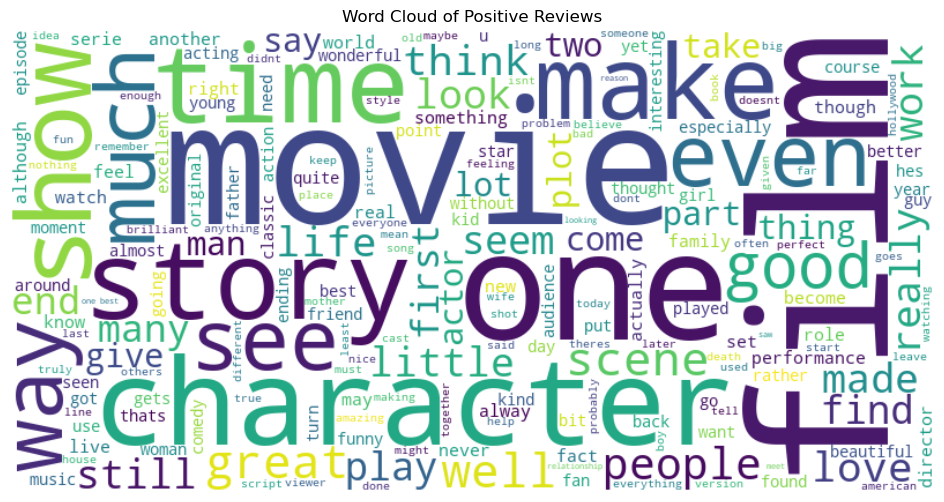

In [37]:
plt.figure(figsize=(15,6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

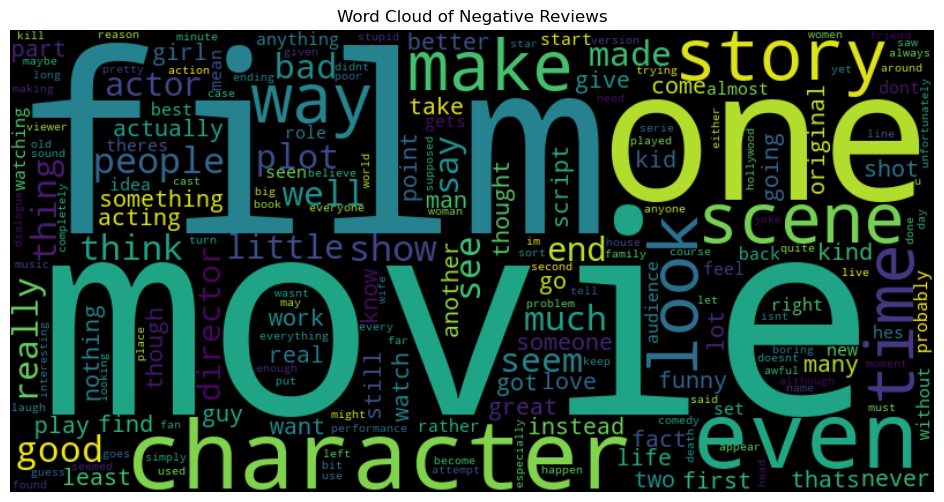

In [38]:
plt.figure(figsize=(15,6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

**Top Words Analysis**

In [40]:
# Function to get word frequencies for a text
def get_word_frequencies(text):
    word_counts = {}
    for word in text.split():
        word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts


positive_word_counts = get_word_frequencies(positive_text)
negative_word_counts = get_word_frequencies(negative_text)

positive_top_words = pd.DataFrame(sorted(positive_word_counts.items(), key=lambda x: x[1], reverse=True)[:20], columns=['word', 'count'])
negative_top_words = pd.DataFrame(sorted(negative_word_counts.items(), key=lambda x: x[1], reverse=True)[:20], columns=['word', 'count'])


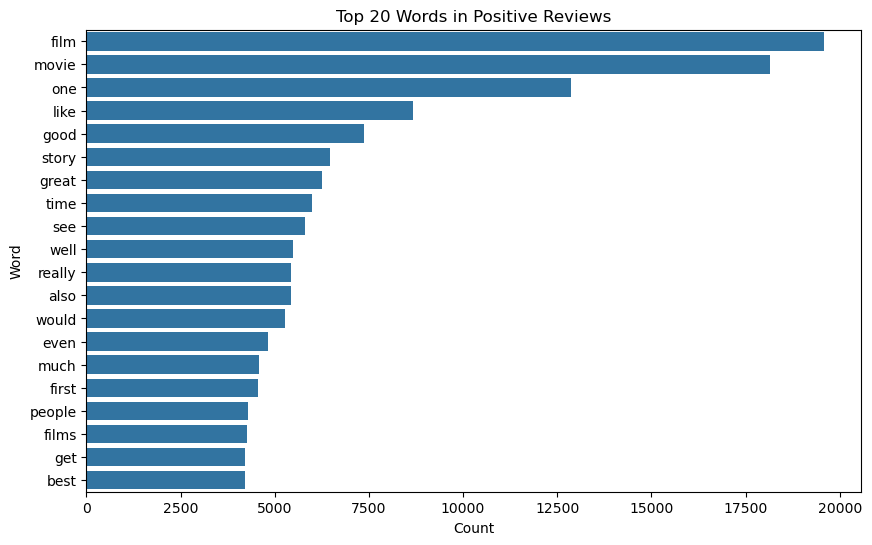

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='word', data=positive_top_words)
plt.title('Top 20 Words in Positive Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

**Top 20 Words in Positive Reviews**:
   - The bar chart indicates that the most frequent words in positive reviews include "film," "movie," and "one."
   - Positive sentiment words like "good," "great," and "best" are prominent.
   - The frequent use of these words reflects a focus on discussing quality and appreciation in positive reviews.


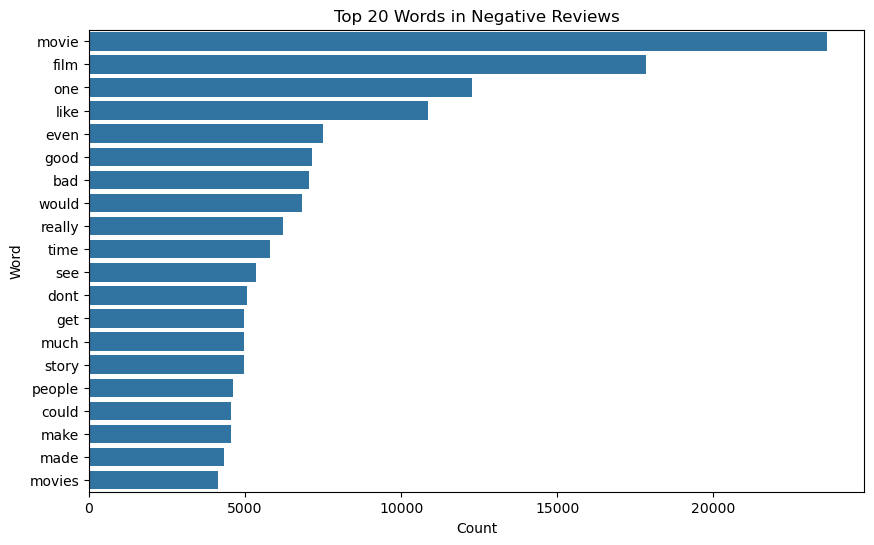

In [43]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='word', data=negative_top_words)
plt.title('Top 20 Words in Negative Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

**Top 20 Words in Negative Reviews**:
   - Words like "movie," "film," and "one" also dominate the negative reviews, showing they are core to movie discussions irrespective of sentiment.
   - Negative sentiment is captured by words such as "bad," and "don't," which stand out.
   - The presence of words like "could," "would," and "made" suggests critiques of what the movie could have done better.

**Handling Rare Words**

We replace rare words with a special <UNK> token to reduce vocabulary size and handle unseen words.

In [46]:
# Function to get word counts for all reviews
def get_word_counts(reviews):
    word_counts = {}
    for review in reviews:
        words = review.split()
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts

# Get word counts from training data
word_counts = get_word_counts(train_data['review'])


<span style="color: orange;">I experminted with different threshholds like 5, 8, 10, 20 and got the best results with 3. </span>


In [48]:
threshold = 3
rare_words = set([word for word, count in word_counts.items() if count < threshold])


Final Preprocessing Function to Handle Rare Words

In [50]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text.lower())
    text = re.sub(r'[^\w\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [word if word not in rare_words else '<UNK>' for word in tokens]
    return ' '.join(tokens)
    

In [51]:
# Apply preprocessing to training data
train_data['clean_review'] = train_data['review'].apply(preprocess_text)

# Apply preprocessing to test data using the same rare_words
test_data['clean_review'] = test_data['review'].apply(preprocess_text)


Preprocessing example for a single review

In [53]:
print("Original Review:\n", train_data['review'].iloc[0])
print("\nCleaned Review:\n", train_data['clean_review'].iloc[0])

Original Review:
 In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupted with a corpse that contains plague. As cop Paul Douglas properly points out the guy died from two bullets in the chest. That's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.<br /><br />As was pointed out by any number of people, for some reason director Elia Kazan did not bother to cast the small parts with anyone that sounds like they're from Louisiana. Having been to New Orleans where the story takes place I can personally attest to that. Richard Widmark and his wife Barbara Bel Geddes can be excused because as a Navy doctor he could be assigned there, but for those that are natives it doesn't work.<br /><br />But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld. The dead guy came off a ship from Europe and he had u

### 4. N-gram Generation and Vocabulary Creation

1. **Unigrams**:
   - Single words treated as features (e.g., "good," "bad").
   - Captures individual word frequencies, making it simple and effective for identifying sentiment-related words.
   - Limited context; lacks relationships between words.

2. **Bigrams**:
   - Two consecutive words as features (e.g., "not good," "very bad").
   - Captures short-term context and word pair dependencies, enhancing sentiment analysis accuracy.
   - More sensitive to word order compared to unigrams.

3. **Trigrams**:
   - Three consecutive words as features (e.g., "not at all," "really very bad").
   - Captures longer dependencies and nuanced phrases, which can provide additional context.
   - Suffers from sparsity; requires more data to be effective.

Generating N-grams

In [57]:
def generate_ngrams(text, n):
    tokens = text.split()
    ngrams = list(zip(*[tokens[i:] for i in range(n)]))
    return ['_'.join(ngram) for ngram in ngrams]

train_data['unigrams'] = train_data['clean_review'].apply(lambda x: generate_ngrams(x, 1))
train_data['bigrams'] = train_data['clean_review'].apply(lambda x: generate_ngrams(x, 2))
train_data['trigrams'] = train_data['clean_review'].apply(lambda x: generate_ngrams(x, 3))

Creating Vocabularies

In [59]:
# Build vocabulary for unigrams
all_unigrams = [word for tokens in train_data['unigrams'] for word in tokens]
unigram_vocab = set(all_unigrams)
unigram_vocab.add('<UNK>')
unigram_vocab_size = len(unigram_vocab)
print(f'Unigram Vocabulary Size: {unigram_vocab_size}')

# Similarly for bigrams
all_bigrams = [word for tokens in train_data['bigrams'] for word in tokens]
bigram_vocab = set(all_bigrams)
bigram_vocab.add('<UNK>')
bigram_vocab_size = len(bigram_vocab)
print(f'Bigram Vocabulary Size: {bigram_vocab_size}')

# Similarly for trigrams
all_trigrams = [word for tokens in train_data['trigrams'] for word in tokens]
trigram_vocab = set(all_trigrams)
trigram_vocab.add('<UNK>')
trigram_vocab_size = len(trigram_vocab)
print(f'Trigram Vocabulary Size: {trigram_vocab_size}')


Unigram Vocabulary Size: 92068
Bigram Vocabulary Size: 1727434
Trigram Vocabulary Size: 2817852


In [60]:
# Create unigram dictionary
unigram_dict = {word: idx for idx, word in enumerate(unigram_vocab)}

# Create bigram dictionary
bigram_dict = {word: idx for idx, word in enumerate(bigram_vocab)}

# Create trigram dictionary
trigram_dict = {word: idx for idx, word in enumerate(trigram_vocab)}


### 5. Naive Bayes Classifier Implementation

Separating Data by Class

In [63]:
# Separate the training data by class
train_pos = train_data[train_data['label'] == 1]
train_neg = train_data[train_data['label'] == 0]

Calculating N-gram Counts

In [65]:
def get_ngram_counts(tokens_list):
    ngram_counts = {}
    for tokens in tokens_list:
        for token in tokens:
            ngram_counts[token] = ngram_counts.get(token, 0) + 1
    return ngram_counts
    

In [66]:
# Get unigram counts
pos_unigram_counts = get_ngram_counts(train_pos['unigrams'])
neg_unigram_counts = get_ngram_counts(train_neg['unigrams'])

# Get bigram counts
pos_bigram_counts = get_ngram_counts(train_pos['bigrams'])
neg_bigram_counts = get_ngram_counts(train_neg['bigrams'])

# Get trigram counts
pos_trigram_counts = get_ngram_counts(train_pos['trigrams'])
neg_trigram_counts = get_ngram_counts(train_neg['trigrams'])


Calculating Prior Probabilities

In [68]:
# Calculate prior probabilities
total_reviews = len(train_data)
pos_prior = len(train_pos) / total_reviews
neg_prior = len(train_neg) / total_reviews

# Calculate log prior probabilities
log_pos_prior = math.log(pos_prior)
log_neg_prior = math.log(neg_prior)


Preprocessing Test Data

In [70]:
# Apply preprocessing
test_data['clean_review'] = test_data['review'].apply(preprocess_text)
test_data['unigrams'] = test_data['clean_review'].apply(lambda x: generate_ngrams(x, 1))
test_data['bigrams'] = test_data['clean_review'].apply(lambda x: generate_ngrams(x, 2))
test_data['trigrams'] = test_data['clean_review'].apply(lambda x: generate_ngrams(x, 3))

In [71]:
def replace_unknowns(tokens, vocab):
    return [token if token in vocab else '<UNK>' for token in tokens]

test_data['unigrams'] = test_data['unigrams'].apply(lambda x: replace_unknowns(x, unigram_vocab))
test_data['bigrams'] = test_data['bigrams'].apply(lambda x: replace_unknowns(x, bigram_vocab))
test_data['trigrams'] = test_data['trigrams'].apply(lambda x: replace_unknowns(x, trigram_vocab))

Prediction Functions

In [73]:
def calculate_log_likelihood(tokens, class_counts, class_total_count, vocab_size):
    log_likelihood = 0
    for token in tokens:
        # Apply Laplace smoothing
        token_count = class_counts.get(token, 0) + 1
        # Calculate the probability
        token_prob = token_count / (class_total_count + vocab_size)
        # Sum the log probabilities
        log_likelihood += math.log(token_prob)
    return log_likelihood


In [74]:
def predict_ngram(tokens, pos_counts, neg_counts, pos_total_count, neg_total_count, vocab_size, log_pos_prior, log_neg_prior):
    # Calculate log-likelihoods
    pos_log_likelihood = calculate_log_likelihood(tokens, pos_counts, pos_total_count, vocab_size)
    neg_log_likelihood = calculate_log_likelihood(tokens, neg_counts, neg_total_count, vocab_size)
    
    # Calculate posterior probabilities (log scale)
    pos_score = log_pos_prior + pos_log_likelihood
    neg_score = log_neg_prior + neg_log_likelihood
    
    # Predict class
    return 1 if pos_score > neg_score else 0


Predicting with Combined Model
   - Leverages the strengths of all n-grams, capturing both individual word importance (unigrams) and contextual relationships (bigrams and trigrams).

In [76]:
def predict_combined(unigrams, bigrams, trigrams):
    # Unigram likelihood
    pos_score_uni = calculate_log_likelihood(unigrams, pos_unigram_counts, pos_unigram_total_count, unigram_vocab_size)
    neg_score_uni = calculate_log_likelihood(unigrams, neg_unigram_counts, neg_unigram_total_count, unigram_vocab_size)
    
    # Bigram likelihood
    pos_score_bi = calculate_log_likelihood(bigrams, pos_bigram_counts, pos_bigram_total_count, bigram_vocab_size)
    neg_score_bi = calculate_log_likelihood(bigrams, neg_bigram_counts, neg_bigram_total_count, bigram_vocab_size)
    
    # Bigram likelihood
    pos_score_tri = calculate_log_likelihood(trigrams, pos_trigram_counts, pos_trigram_total_count, trigram_vocab_size)
    neg_score_tri = calculate_log_likelihood(trigrams, neg_trigram_counts, neg_trigram_total_count, trigram_vocab_size)
    
    # Combine scores with priors
    pos_score = log_pos_prior + pos_score_uni + pos_score_bi + pos_score_tri
    neg_score = log_neg_prior + neg_score_uni + neg_score_bi + neg_score_tri
    
    # Predict class
    return 1 if pos_score > neg_score else 0


Total Counts for N-grams

In [78]:
# Total counts for unigrams
pos_unigram_total_count = sum(pos_unigram_counts.values())
neg_unigram_total_count = sum(neg_unigram_counts.values())

# Total counts for bigrams
pos_bigram_total_count = sum(pos_bigram_counts.values())
neg_bigram_total_count = sum(neg_bigram_counts.values())

# Total counts for trigrams
pos_trigram_total_count = sum(pos_trigram_counts.values())
neg_trigram_total_count = sum(neg_trigram_counts.values())


Making Predictions

In [80]:
# Predictions for unigram
test_data['unigram_prediction'] = test_data['unigrams'].apply(
    lambda tokens: predict_ngram(
        tokens,
        pos_unigram_counts,
        neg_unigram_counts,
        pos_unigram_total_count,
        neg_unigram_total_count,
        unigram_vocab_size,
        log_pos_prior,
        log_neg_prior
    )
)

# Predictions for bigram
test_data['bigram_prediction'] = test_data['bigrams'].apply(
    lambda tokens: predict_ngram(
        tokens,
        pos_bigram_counts,
        neg_bigram_counts,
        pos_bigram_total_count,
        neg_bigram_total_count,
        bigram_vocab_size,
        log_pos_prior,
        log_neg_prior
    )
)

# Predictions for trigram
test_data['trigram_prediction'] = test_data['trigrams'].apply(
    lambda tokens: predict_ngram(
        tokens,
        pos_trigram_counts,
        neg_trigram_counts,
        pos_trigram_total_count,
        neg_trigram_total_count,
        trigram_vocab_size,
        log_pos_prior,
        log_neg_prior
    )
)

# Predictions for combined approach
test_data['combined_prediction'] = test_data.apply(
    lambda row: predict_combined(
        row['unigrams'],
        row['bigrams'],
        row['trigrams']
    ),
    axis=1
)


### 6. Model Evaluation

Evaluation Function

In [83]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f'\n{model_name} Evaluation:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    return accuracy, precision, recall, f1

Evaluating Models

In [85]:
y_true = test_data['label']

# Evaluate Unigram Model
accuracy_unigram, precision_unigram, recall_unigram, f1_score_unigram = evaluate_model(
    y_true, test_data['unigram_prediction'], 'Unigram Model')

# Evaluate Bigram Model
accuracy_bigram, precision_bigram, recall_bigram, f1_score_bigram = evaluate_model(
    y_true, test_data['bigram_prediction'], 'Bigram Model')

# Evaluate Trigram Model
accuracy_trigram, precision_trigram, recall_trigram, f1_score_trigram = evaluate_model(
    y_true, test_data['trigram_prediction'], 'Trigram Model')

# Evaluate Combined Model
accuracy_combined, precision_combined, recall_combined, f1_score_combined = evaluate_model(
    y_true, test_data['combined_prediction'], 'Combined Model')


Unigram Model Evaluation:
Accuracy: 0.8316
Precision: 0.8624
Recall: 0.7890
F1-Score: 0.8241

Bigram Model Evaluation:
Accuracy: 0.8467
Precision: 0.8982
Recall: 0.7821
F1-Score: 0.8361

Trigram Model Evaluation:
Accuracy: 0.7071
Precision: 0.8371
Recall: 0.5142
F1-Score: 0.6371

Combined Model Evaluation:
Accuracy: 0.8566
Precision: 0.9020
Recall: 0.8002
F1-Score: 0.8480


Comparing Model Performance

In [87]:
# Create a DataFrame to display the results
evaluation_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Unigram Model': [accuracy_unigram, precision_unigram, recall_unigram, f1_score_unigram],
    'Bigram Model': [accuracy_bigram, precision_bigram, recall_bigram, f1_score_bigram],
    'Trigram Model': [accuracy_trigram, precision_trigram, recall_trigram, f1_score_trigram],
    'Combined Model': [accuracy_combined, precision_combined, recall_combined, f1_score_combined]
})

# Display the results
evaluation_df.set_index('Metric', inplace=True)
print(evaluation_df)


           Unigram Model  Bigram Model  Trigram Model  Combined Model
Metric                                                               
Accuracy        0.831560      0.846720       0.707080        0.856600
Precision       0.862440      0.898199       0.837088        0.901975
Recall          0.788960      0.782080       0.514240        0.800160
F1-Score        0.824065      0.836127       0.637098        0.848022


| Metric         | Unigram Model | Bigram Model | Trigram Model | Combined Model |
|----------------|---------------|--------------|---------------|----------------|
| Accuracy       | 0.831560      | 0.846720     | 0.707080      | 0.856600       |
| Precision      | 0.862440      | 0.898199     | 0.837088      | 0.901975       |
| Recall         | 0.788960      | 0.782080     | 0.514240      | 0.800160       |
| F1-Score       | 0.824065      | 0.836127     | 0.637098      | 0.848022       |


- **Unigram Model**: Achieved a solid baseline performance with an accuracy of 83.16%. It captures individual word frequencies but lacks contextual understanding.
- **Bigram Model**: Improved accuracy to 84.67% by considering pairs of words, capturing some context.
- **Trigram Model**: Lower accuracy of 70.71% due to data sparsity; trigrams are less frequent and require more data to be effective.
- **Combined Model**: Highest accuracy of 85.66%, demonstrating that combining different n-gram levels captures more nuanced patterns in the text.


#### Plots for better understanding

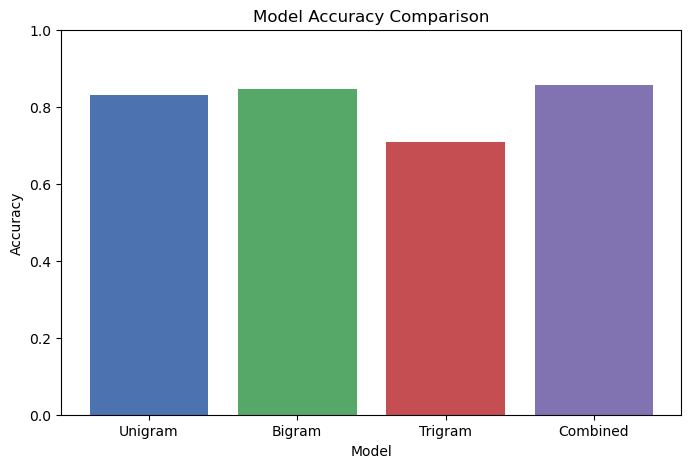

In [91]:
accuracies = {
    'Unigram': accuracy_unigram,
    'Bigram': accuracy_bigram,
    'Trigram': accuracy_trigram,
    'Combined': accuracy_combined
}

# Plotting accuracies
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


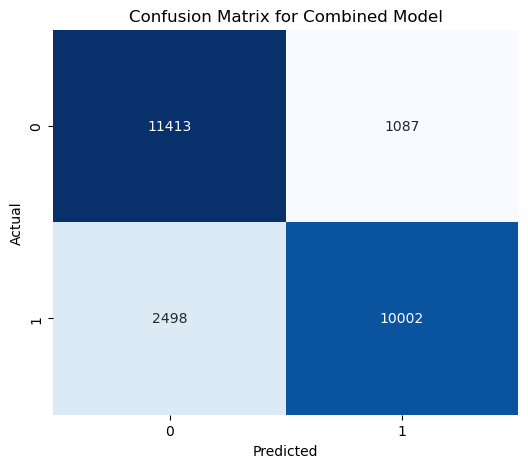

In [92]:
cm = confusion_matrix(test_data['label'], test_data['combined_prediction'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Combined Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 7. Discussion of Results

#### 1. **Accuracy**
   - **Comment**: The Combined Model achieves the highest accuracy (85.66%), followed by the Bigram Model (84.67%) and Unigram Model (83.16%). The Trigram Model achieves the lowest at 70.71%.
   - **Discussion**: 
     - Unigrams are effective due to their simplicity, but they fail to capture word dependencies.
     - Bigrams improve accuracy by incorporating word pair relationships, which add context.
     - Trigrams struggle due to data sparsity, as three-word combinations are less frequent and harder to generalize.
     - The Combined Model excels by leveraging the strengths of all n-gram types, capturing both individual word importance and contextual patterns.

#### 2. **Precision**
   - **Comment**: Precision is highest for the Combined Model (90.20%) and Bigram Model (89.82%), while the Trigram Model is slightly lower (83.71%). The Unigram Model has the lowest precision (86.24%).
   - **Discussion**:
     - Higher precision indicates fewer false positives. The Combined Model is more robust in correctly identifying positive reviews.
     - The lower precision of the Unigram Model reflects its inability to consider context, which can lead to misclassification of certain words.

#### 3. **Recall**
   - **Comment**: Recall is highest for the Combined Model (80.02%), followed by the Unigram Model (78.89%) and Bigram Model (78.20%). The Trigram Model has the lowest recall (51.42%).
   - **Discussion**:
     - Recall measures the model's ability to identify true positives. The low recall of the Trigram Model shows it struggles to correctly identify many positive reviews, likely due to its reliance on rare patterns.
     - The Combined Model balances recall effectively by integrating broader context from all n-grams.

#### 4. **F1-Score**
   - **Comment**: The Combined Model has the highest F1-score (84.80%), followed by the Bigram Model (83.61%) and Unigram Model (82.41%). The Trigram Model has the lowest F1-score (63.71%).
   - **Discussion**:
     - The F1-score balances precision and recall. The Combined Model's high score highlights its ability to reduce both false positives and false negatives.
     - The Trigram Model's low score confirms its inefficiency, particularly in recall, despite having decent precision.

#### Overall Discussion
- **Combined Model**: Outperforms all other models by effectively capturing both individual word importance (unigrams) and contextual relationships (bigrams and trigrams), resulting in the best balance between precision, recall, and accuracy.
- **Bigram Model**: Performs well, especially in precision, as it captures common word pairs and context effectively. It is a simpler and computationally less expensive alternative to the Combined Model.
- **Unigram Model**: Provides a solid baseline with good performance in all metrics but lacks the ability to consider contextual word relationships.
- **Trigram Model**: Struggles due to data sparsity and reliance on longer n-grams, which require a larger dataset for effective generalization.

# **PART III: Bonus Part**

Reinitialize the dataset to avoid any confusion

In [97]:
# Create DataFrames
train_data = pd.DataFrame({'review': train_reviews, 'label': train_labels})
test_data = pd.DataFrame({'review': test_reviews, 'label': test_labels})

# Shuffle the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [98]:
!pip install gensim

In [99]:
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


**Preprocessing Function**
- I defined a function preprocess_text_for_tfidf to preprocess the text data, using nltk's stopwords.

In [101]:
def preprocess_text_for_tfidf(text):
    text = re.sub(r'<.*?>', ' ', text.lower())
    text = re.sub(r'[^\w\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

train_data['clean_review'] = train_data['review'].apply(preprocess_text_for_tfidf)
test_data['clean_review'] = test_data['review'].apply(preprocess_text_for_tfidf)


### Model 1: Logistic Regression with TF-IDF Features

**Feature Extraction with TF-IDF**
- I used the TfidfVectorizer from scikit-learn to convert text data into TF-IDF features.

In [104]:
# Create TF-IDF vectorizer with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3)

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(train_data['clean_review'])

# Transform test data
X_test_tfidf = vectorizer.transform(test_data['clean_review'])


**Training the Logistic Regression Model**

In [106]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_tfidf, train_data['label'])

# Predict on test data
y_pred_tfidf = lr_model.predict(X_test_tfidf)


**Model Evaluation**

In [108]:
# Calculate evaluation metrics
accuracy_tfidf = accuracy_score(test_data['label'], y_pred_tfidf)
precision_tfidf = precision_score(test_data['label'], y_pred_tfidf)
recall_tfidf = recall_score(test_data['label'], y_pred_tfidf)
f1_tfidf = f1_score(test_data['label'], y_pred_tfidf)

print('Logistic Regression with TF-IDF Evaluation:')
print(f'Accuracy: {accuracy_tfidf:.4f}')
print(f'Precision: {precision_tfidf:.4f}')
print(f'Recall: {recall_tfidf:.4f}')
print(f'F1-Score: {f1_tfidf:.4f}')


Logistic Regression with TF-IDF Evaluation:
Accuracy: 0.8900
Precision: 0.8881
Recall: 0.8925
F1-Score: 0.8903


### Model 2: Logistic Regression with Word2Vec Embeddings

**Loading Pre-trained Word2Vec Model**

- We used Google's pre-trained Word2Vec model to obtain word embeddings:

In [111]:
word2vec_model = api.load('word2vec-google-news-300')  # May take a while to download


**Function to Compute Document Vectors**

We defined a function to compute the embeddings in a document:

In [113]:
# Function to compute the average word embedding for a document
def get_document_embedding(text, model):
    tokens = text.split()
    embeddings = []
    for token in tokens:
        if token in model.key_to_index:
            embeddings.append(model.get_vector(token))
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)
        
# Compute embeddings for training data
X_train_embeddings = np.array([
    get_document_embedding(text, word2vec_model) for text in train_data['clean_review']
])

# Compute embeddings for test data
X_test_embeddings = np.array([
    get_document_embedding(text, word2vec_model) for text in test_data['clean_review']
])


**Training the Logistic Regression Model**

In [115]:
# Initialize Logistic Regression model
lr_model_embedding = LogisticRegression(max_iter=1000)

# Train the model
lr_model_embedding.fit(X_train_embeddings, train_data['label'])

# Predict on test data
y_pred_embeddings = lr_model_embedding.predict(X_test_embeddings)

**Model Evaluation**

In [117]:
# Calculate evaluation metrics
accuracy_embeddings = accuracy_score(test_data['label'], y_pred_embeddings)
precision_embeddings = precision_score(test_data['label'], y_pred_embeddings)
recall_embeddings = recall_score(test_data['label'], y_pred_embeddings)
f1_embeddings = f1_score(test_data['label'], y_pred_embeddings)

print('Logistic Regression with Word Embeddings Evaluation:')
print(f'Accuracy: {accuracy_embeddings:.4f}')
print(f'Precision: {precision_embeddings:.4f}')
print(f'Recall: {recall_embeddings:.4f}')
print(f'F1-Score: {f1_embeddings:.4f}')

Logistic Regression with Word Embeddings Evaluation:
Accuracy: 0.8532
Precision: 0.8558
Recall: 0.8494
F1-Score: 0.8526


In [118]:
evaluation_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Naive Bayes n-gram': [accuracy_combined, precision_combined, recall_combined, f1_score_combined],
    'LogReg TF-IDF': [accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf],
    'LogReg Word2Vec': [accuracy_embeddings, precision_embeddings, recall_embeddings, f1_embeddings]
})

# Display the results
evaluation_df.set_index('Metric', inplace=True)
print(evaluation_df)


           Naive Bayes n-gram  LogReg TF-IDF  LogReg Word2Vec
Metric                                                       
Accuracy             0.856600       0.890040         0.853160
Precision            0.901975       0.888146         0.855807
Recall               0.800160       0.892480         0.849440
F1-Score             0.848022       0.890308         0.852612


Plots for better understanding

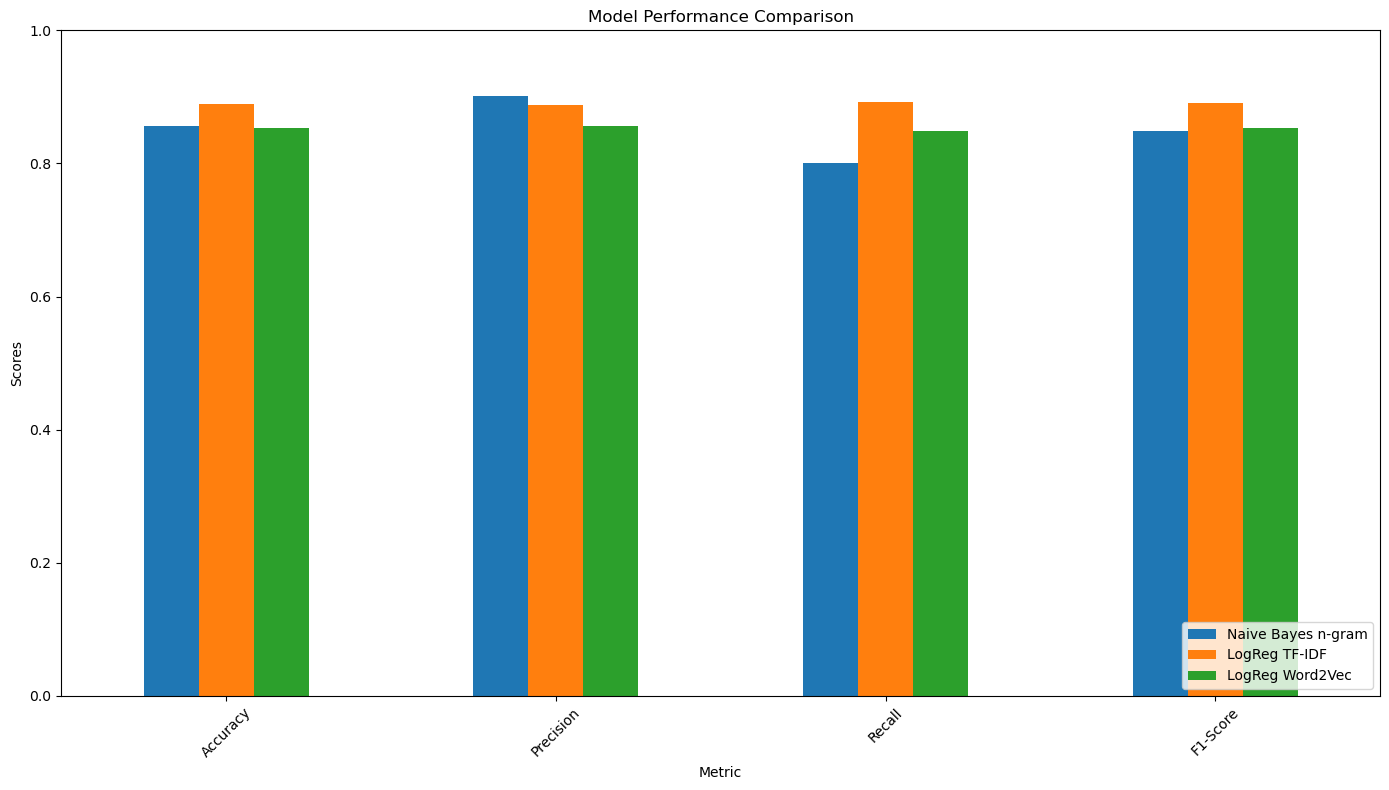

In [120]:
# Plot the comparison metrics
evaluation_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Discussion of Results
| Metric       | Naive Bayes n-gram | Logistic Regression with TF-IDF | Logistic Regression with Word2Vec |
|--------------|--------------------|---------------------------------|-----------------------------------|
| **Accuracy** | 85.66%             | **89.00%**                      | 85.32%                            |
| **Precision**| **90.20%**         | 88.81%                          | 85.58%                            |
| **Recall**   | 80.02%             | **89.25%**                      | 84.94%                            |
| **F1-Score** | 84.80%             | **89.03%**                      | 85.26%                            |

The Logistic Regression model with TF-IDF features outperformed the other two approaches. Here's why I think this happened:

**1. Logistic Regression with TF-IDF:**

- **Capturing Important Words:** TF-IDF helps highlight the most significant words in the reviews by giving higher weights to words that are unique and informative. This means words that strongly indicate positive or negative sentiment have more influence.
- **Effective Modeling:** Logistic Regression is great at handling large feature spaces and finds the best way to separate positive and negative reviews based on these important words.
- **Preserving Context with N-grams:** By using unigrams, bigrams, and trigrams in TF-IDF, the model captures phrases and word combinations that are crucial for understanding sentiment, like "not good" or "really enjoyed."

**2. Naive Bayes with n-grams:**

- **Decent Performance:** It did pretty well but wasn't as accurate as the TF-IDF approach.
- **Assumption Limitations:** Naive Bayes assumes that all features (words) are independent of each other, which isn't always true in language. This might have limited its ability to fully grasp the sentiment nuances in the reviews.

**3. Logistic Regression with Word2Vec:**

- **Lower Performance:** This approach had slightly lower accuracy and F1-score compared to the other two.
- **Loss of Context:** Averaging word embeddings might have caused the model to miss out on important word order and context. For example, "not bad" could be misinterpreted if the model doesn't consider the word "not" properly.
- **Embeddings Not Specific to Sentiment:** Word2Vec model was trained on Google News data, it might not be perfectly suited for movie reviews, missing out on domain-specific sentiments.

**In Summary:**

- **Why TF-IDF Worked Best:** It emphasizes the most relevant words and phrases that indicate sentiment, and Logistic Regression effectively uses this information to classify the reviews accurately.
- **Why Word Embeddings Didn't Perform as Well:** Averaging embeddings can blur important distinctions between words, and without capturing the sequence of words or focusing on sentiment-specific features, the model might not fully understand the sentiment expressed.


## **Important Note Regarding the Bonus Part** 

- I wanted to experiment with hyperparameters that I used in the bonus part and wanted to share some observations regarding hyperparameter tuning.

- I attempted to implement hyperparameter tuning using Grid Search with cross-validation for both the Logistic Regression model with TF-IDF features and the Logistic Regression model with Word Embeddings. However, I encountered some challenges:

1. **Computational Time:** The hyperparameter tuning process was extremely time-consuming (more than hours) due to the size of the dataset and the extensive parameter grid. Running the Grid Search for the TF-IDF model and the Word Embedding model took a significant amount of time, which was not practical.

2. **Marginal Improvements:** Despite the prolonged computational effort, the results did not show a substantial improvement over the untuned models. The performance metrics improved only slightly, which did not justify the computational cost.

Here are the results I obtained:

| Metric     | Naive Bayes n-gram | LogReg TF-IDF (Before Tuning) | LogReg TF-IDF (Tuned) | LogReg Word2Vec (Before Tuning) | LogReg Word2Vec (Tuned) |
|------------|--------------------|-------------------------------|-----------------------|-------------------------------|-----------------------|
| **Accuracy**   | 0.8566             | 0.8900                        | 0.8950                | 0.8532                        | 0.8585                |
| **Precision**  | 0.9020             | 0.8881                        | 0.9000                | 0.8558                        | 0.8592                |
| **Recall**     | 0.8002             | 0.8925                        | 0.8887                | 0.8494                        | 0.8575                |
| **F1-Score**   | 0.8480             | 0.8903                        | 0.8943                | 0.8526                        | 0.8583                |

As shown in the table, the tuned models offered only a slight increase in accuracy and F1-score compared to the untuned versions. Given the minimal gains and the significant computational resources required, I decided to omit the hyperparameter tuning from the final implementation.

## Here is the code that I used for hyperparameter tuning

### For Logistic Regression with TF-IDF features

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define parameter grid
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__use_idf': [True, False],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga']
}

# Initialize Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(train_data['clean_review'], train_data['label'])

- Fitting 3 folds for each of 432 candidates, totalling 1296 fits

# Best hyperparameters
print("Best Hyperparameters:\n", grid_search.best_params_)

# Predict on test data
best_model = grid_search.best_estimator_
y_pred_tfidf_tuned = best_model.predict(test_data['clean_review'])

# Calculate evaluation metrics
accuracy_tfidf_tuned = accuracy_score(test_data['label'], y_pred_tfidf_tuned)
precision_tfidf_tuned = precision_score(test_data['label'], y_pred_tfidf_tuned)
recall_tfidf_tuned = recall_score(test_data['label'], y_pred_tfidf_tuned)
f1_tfidf_tuned = f1_score(test_data['label'], y_pred_tfidf_tuned)

print('\nTuned Logistic Regression with TF-IDF Evaluation:')
print(f'Accuracy: {accuracy_tfidf_tuned:.4f}')
print(f'Precision: {precision_tfidf_tuned:.4f}')
print(f'Recall: {recall_tfidf_tuned:.4f}')
print(f'F1-Score: {f1_tfidf_tuned:.4f}')
```

Best Hyperparameters:
```plaintext
{'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'tfidf__max_df': 0.9, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3), 'tfidf__use_idf': True}
```

Tuned Logistic Regression with TF-IDF Evaluation:
```plaintext
Accuracy: 0.8950
Precision: 0.9000
Recall: 0.8887
F1-Score: 0.8943
```

---

### For Logistic Regression with Word Embeddings

```python
from sklearn.preprocessing import FunctionTransformer

# Function to transform text data into word embeddings using get_document_embedding
def document_vector_transform(docs):
    return np.array([get_document_embedding(doc, word2vec_model) for doc in docs])

# Create a transformerrmer
embedding_transformer = FunctionTransformer(document_vector_transform, validate=False)

# Define the pipeline
pipeline_w2v = Pipeline([
    ('embedding', embedding_transformer),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define parameter grid
param_grid_w2v = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga'],
    'logreg__class_weight': [None, 'balanced']
}

# Initialize Grid Search
grid_search_w2v = GridSearchCV(
    pipeline_w2v,
    param_grid_w2v,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_w2v.fit(train_data['clean_review'], train_data['label'])

- Fitting 3 folds for each of 20 candidates, totalling 60 fits

# Best hyperparameters
print("Best Hyperparameters for Word Embeddings:\n", grid_search_w2v.best_params_)
```

Best Hyperparameters for Word Embeddings:
```plaintext
{'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
```

```python
# Predict on test data
best_model_w2v = grid_search_w2v.best_estimator_
y_pred_w2v_tuned = best_model_w2v.predict(test_data['clean_review'])

# Calculate evaluation metrics
accuracy_w2v_tuned = accuracy_score(test_data['label'], y_pred_w2v_tuned)
precision_w2v_tuned = precision_score(test_data['label'], y_pred_w2v_tuned)
recall_w2v_tuned = recall_score(test_data['label'], y_pred_w2v_tuned)
f1_w2v_tuned = f1_score(test_data['label'], y_pred_w2v_tuned)

print('\nTuned Logistic Regression with Word Embeddings Evaluation:')
print(f'Accuracy: {accuracy_w2v_tuned:.4f}')
print(f'Precision: {precision_w2v_tuned:.4f}')
print(f'Recall: {recall_w2v_tuned:.4f}')
print(f'F1-Score: {f1_w2v_tuned:.4f}')
```

Tuned Logistic Regression with Word Embeddings Evaluation:
```plaintext
Accuracy: 0.8585
Precision: 0.8592
Recall: 0.8575
F1-Score: 0.8583
```
```